In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('tweet.csv',  encoding= 'unicode_escape')

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Data Preprocessing

In [4]:
df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}, inplace = True)

In [5]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
df.isna().sum()

tweet_text                            1
emotion_in_tweet_is_directed_at    5802
emotion                               0
dtype: int64

### Removing the row where tweet text is missing 

In [11]:
df.dropna(subset = ['tweet_text'], inplace = True)

In [12]:
df.isna().sum()

tweet_text                            0
emotion_in_tweet_is_directed_at    5801
emotion                               0
dtype: int64

In [14]:
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

### Removing "I can't tell" 

In [19]:
df.drop(df[df['emotion'] == 'I can\'t tell'].index, inplace = True)

In [21]:
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

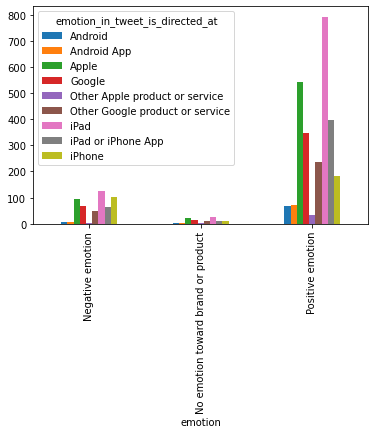

In [36]:
df.groupby(['emotion', 'emotion_in_tweet_is_directed_at']).emotion.count().unstack().plot(kind = 'bar')